<a href="https://colab.research.google.com/github/joeldmott/inventory_project/blob/main/inventory_restocking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
import kaggle
! kaggle datasets download joelmott/liquor-inventory-dataset

Dataset URL: https://www.kaggle.com/datasets/joelmott/liquor-inventory-dataset
License(s): MIT
 96% 158M/164M [00:02<00:00, 61.9MB/s]
100% 164M/164M [00:02<00:00, 67.1MB/s]


In [3]:
!unzip /content/liquor-inventory-dataset.zip

Archive:  /content/liquor-inventory-dataset.zip
  inflating: Iowa_Liquor_Sales_2017_thru_2023.csv  


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('/content/Iowa_Liquor_Sales_2017_thru_2023.csv')
df.head()

,Date,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
0,01/03/2017,5230,POINT LIQUOR & TOBACCO,NaN,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,3
1,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,AMERICAN VODKAS,434.0,LUXCO INC,6
2,01/03/2017,5359,FAREWAY STORES # 168/ PEOSTA,PEOSTA,AMERICAN VODKAS,434.0,LUXCO INC,12
3,01/03/2017,5242,KUM & GO #502 / IOWA CITY,NaN,AMERICAN VODKAS,260.0,DIAGEO AMERICAS,1
4,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,COCKTAILS/RTD,395.0,PROXIMO,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468378 entries, 0 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Date           object 
 1   Store Number   int64  
 2   Store Name     object 
 3   City           object 
 4   Category Name  object 
 5   Vendor Number  float64
 6   Vendor Name    object 
 7   Bottles Sold   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 1.0+ GB


In [6]:
#What's the date range?
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2023-12-30 00:00:00'))

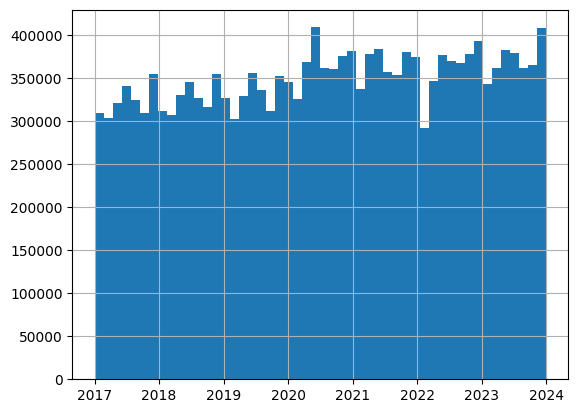

In [7]:
df['Date'].hist(bins=50);

Obviously, we'll drop the random few date entries from 2016-2018, but the real tragedy here is the missing data from the very end of 2015. I don't think it's a good idea to try and impute and time-series data here, so we'll have to drop everything after January 3rd, 2015. However, this still gives us three complete years of data, which isn't bad.

In [8]:
#trimmed_df = df[~(df['Date'] > '2017-01-03 00:00:00')]
#trimmed_df['Date'].hist(bins=60);

With our time-series data sorted out, let's examine the amount of stores we have.

In [9]:
#How many stores?
unique_stores = df['Store Number'].unique()
len(unique_stores)

2636

In [10]:
#How many with more than 100 orders in here?
store_value_counts = df['Store Number'].value_counts()
hundred_order_stores = pd.DataFrame(store_value_counts)
hundred_order_stores = hundred_order_stores[hundred_order_stores['count'] >= 100]
len(hundred_order_stores)

2540

In [11]:
#How many with more than 1000 orders in here?
store_value_counts = df['Store Number'].value_counts()
thousand_order_stores = pd.DataFrame(store_value_counts)
thousand_order_stores = thousand_order_stores[thousand_order_stores['count'] >= 1000]
len(thousand_order_stores)

2013

That's a good amount of stores with a decent amount of rows to examine. We may wind up looking at the top ten or top 100 stores only depending on how the project goes.

Let's also look at vendors; while stores represent a variable that we may use to *subdivide* the dataset, vendors will remain an independent variable. As a categorical variable, they may balloon out to an overwhelming number of one-hot encoded variables, so we'll alomost certainly need to find a way to limit these.

In [12]:
#How many vendors total?
len(df['Vendor Name'].unique())

436

In [13]:
#How many with more than 100 orders in here?
vendor_value_counts = df['Vendor Name'].value_counts()
hundred_order_vendors = pd.DataFrame(vendor_value_counts)
hundred_order_vendors = hundred_order_vendors[hundred_order_vendors['count'] >= 100]
len(hundred_order_vendors)

234

In [14]:
#How many with more than 1000 orders in here?
thousand_order_vendors = pd.DataFrame(vendor_value_counts)
thousand_order_vendors = thousand_order_vendors[thousand_order_vendors['count'] >= 1000]
len(thousand_order_vendors)

131

131 vendors combined with the liqour categories and a few more continuous columns is probably still going to be too many to model without a problematic amount of noise and/or sparsity in our data. We may consider adding a limitation here to each store along the way. In other words, when we run a model on an individual store, we'll only include vendors that serviced that store with >= 1,000 orders.

This is especially important when we consider that this dataset covers an entire *state* with urban, suburban, and rural stores that all move different volumes of inventory; the vendors used will almost certainly vary from one store to the next.

Before we start examining stores in more detail, we need to take care of a few other things in our broader DataFrame. Specifically, we need to drop unnecessary columns and contend with what appear to be a few NaNs.

Let's first examine columns so we can see which to drop. I appreciate how the data has store, location, and item names and numbers, but for our purposes, we can drop a number of these redundancies.

Ultimately, if our goal is to predict when and how much to reorder, we can eliminate everything except date, store number, category, and bottles sold, but for now we'll still keep sales info since it's easy to include as a continuous column and we'll keep vendor names in case we want to come back and do more extensive modeling later.

In [15]:
nan_rows = df[df.isna().any(axis=1)]
len(nan_rows)

61953

In [16]:
len(nan_rows) / len(df)

0.0035465799972956846

NaN's only make up 0.36% of our data, so we can afford to drop them without sarcificing much data.

In [17]:
trimmed_df = df.dropna(axis=0)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17406425 entries, 2 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   Store Number   int64         
 2   Store Name     object        
 3   City           object        
 4   Category Name  object        
 5   Vendor Number  float64       
 6   Vendor Name    object        
 7   Bottles Sold   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ GB


Now we can examine the categorical columns more carefully. We'll use the 'Store Number' column later on in order to subdivide the trimmed_df into stores, so let's begin with the 'Category Name' column.

In [18]:
len(trimmed_df['Category Name'].value_counts())

52

In [19]:
print(trimmed_df['Category Name'].value_counts().to_string())

Category Name
AMERICAN VODKAS                         2630640
CANADIAN WHISKIES                       1667195
STRAIGHT BOURBON WHISKIES               1196067
WHISKEY LIQUEUR                          931441
AMERICAN FLAVORED VODKA                  845411
SPICED RUM                               785948
BLENDED WHISKIES                         707707
100% AGAVE TEQUILA                       587622
AMERICAN SCHNAPPS                        562490
IMPORTED VODKAS                          528288
COCKTAILS/RTD                            513808
AMERICAN BRANDIES                        496911
TENNESSEE WHISKIES                       483711
AMERICAN CORDIALS & LIQUEURS             423666
FLAVORED RUM                             416151
IMPORTED CORDIALS & LIQUEURS             399789
WHITE RUM                                379079
MIXTO TEQUILA                            377151
CREAM LIQUEURS                           352825
IMPORTED BRANDIES                        340450
IMPORTED FLAVORED VODKA   

That's too many to include all of them. Instead, we'll carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.

In [20]:
#I can use the str.contains method for some categories that are easier
# to generalize. Let's do those first:
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BOURBON'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Bourbon'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RYE'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rye'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Tequila'), 'Category Name'] = 'TEQUILA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('GIN'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Gin'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RUM'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rum'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('AMARETTO'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Amaretto'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('LIQUEUR'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Liqueur'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('CREME DE'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('COCKTAILS'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Cocktails'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Neutral Grain Spirits'), 'Category Name'] = 'NEUTRAL GRAIN SPIRITS'

In [21]:
#Now we'll make more specific generalizations:

#Whiskies
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch Whiskies', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'SINGLE MALT SCOTCH', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Single Malt Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Canadian Whiskies', 'Category Name'] = 'CANADIAN WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Tennessee Whiskies', 'Category Name'] = 'TENNESSEE WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLENDED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Blended Whiskies', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Irish Whiskies', 'Category Name'] = 'IRISH WHISKIES'

#Vodka
trimmed_df.loc[trimmed_df['Category Name'] == 'VODKA 80 PROOF', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Vodka', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Vodkas', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA - MISC', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == '100 PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'OTHER PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'LOW PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Vodka', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Vodkas', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Flavored Vodka', 'Category Name'] = 'VODKA FLAVORED'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Flavored Vodka', 'Category Name'] = 'VODKA FLAVORED'

#Brandies
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS  BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLACKBERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'APRICOT BRANDIES','Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'CHERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'

#Schnapps
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SCHNAPPS - IMPORTED', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'CINNAMON SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'BUTTERSCOTCH SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'ROOT BEER SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SPEARMINT SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'APPLE SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'WATERMELON SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'RASPBERRY SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'GRAPE SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'STRAWBERRY SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'TROPICAL FRUIT SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'

#other liqueurs
trimmed_df.loc[trimmed_df['Category Name'] == 'TRIPLE SEC','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'Triple Sec','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'ANISETTE', 'Category Name'] = 'LIQUEUR'

In [22]:
#unhelpful categories to drop
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DECANTERS & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'AMERICAN ALCOHOL'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Temporary & Specialty Packages'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Holiday VAP'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Special Order Items'].index)

#getting rid of obscure categories as trade-off for improved model performance
counts = trimmed_df['Category Name'].value_counts()
trimmed_df = trimmed_df[~trimmed_df['Category Name'].isin(counts[counts < 1000].index)]

In [23]:
print('Amount of Revised Liquor Categories:', len(trimmed_df['Category Name'].value_counts()))
print("---------------------------------------")
print(trimmed_df['Category Name'].value_counts().to_string())

Amount of Revised Liquor Categories: 29
---------------------------------------
Category Name
AMERICAN VODKAS                         2630640
LIQUEUR                                 2265635
RUM                                     1729685
CANADIAN WHISKIES                       1667195
BOURBON                                 1256693
AMERICAN FLAVORED VODKA                  845411
BLENDED AND OTHER WHISKIES               841322
100% AGAVE TEQUILA                       587622
AMERICAN SCHNAPPS                        562490
IMPORTED VODKAS                          528288
RTD COCKTAILS                            513808
GIN                                      507723
AMERICAN BRANDIES                        496911
TENNESSEE WHISKIES                       483711
SCOTCH WHISKIES                          395029
MIXTO TEQUILA                            377151
IMPORTED BRANDIES                        340450
IMPORTED FLAVORED VODKA                  307020
TEMPORARY & SPECIALTY PACKAGES           3

In [24]:
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17405965 entries, 2 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   Store Number   int64         
 2   Store Name     object        
 3   City           object        
 4   Category Name  object        
 5   Vendor Number  float64       
 6   Vendor Name    object        
 7   Bottles Sold   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ GB


## moving from the main dataset to individual stores

With that larger-scale data-cleaning process finished, let's start looking toward breaking this data down by store:

In [25]:
#What do, say, the top ten stores look like in terms of sales?
store_counts = trimmed_df['Store Number'].value_counts()
store_counts[0:9]

Store Number
2633    136487
4829    125019
2572    104236
2190     98352
2603     91834
2647     87568
2670     84466
3773     83167
2515     79416
Name: count, dtype: int64

In [26]:
trimmed_df[trimmed_df['Store Number'] == 2572]

,Date,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
141,2017-01-03,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,RUM,434.0,LUXCO INC,3
235,2017-01-03,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,RUM,65.0,JIM BEAM BRANDS,3
309,2017-01-03,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,LIQUEUR,260.0,DIAGEO AMERICAS,4
310,2017-01-03,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,RTD COCKTAILS,395.0,PROXIMO,6
372,2017-01-03,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,AMERICAN SCHNAPPS,434.0,LUXCO INC,4
...,...,...,...,...,...,...,...,...
17458744,2023-12-29,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,100% AGAVE TEQUILA,434.0,LUXCO INC,2
17458889,2023-12-29,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,AMERICAN SCHNAPPS,421.0,SAZERAC COMPANY INC,1
17459003,2023-12-29,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,SCOTCH WHISKIES,420.0,MOET HENNESSY USA,1
17459063,2023-12-29,2572,HY-VEE FOOD STORE / CEDAR FALLS,CEDAR FALLS,TEMPORARY & SPECIALTY PACKAGES,384.0,PIEDMONT DISTILLERS INC,1


In [27]:
#It turns out that store number '2633' is a Hy-Vee in Des Moines.
# We'll isolate this store and save it for further EDA later.
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
#The second-busiest is Central City Liqour, also in Des Moines.
ccl_des_moines = trimmed_df[trimmed_df['Store Number'] == 4829]
#The third-busiest is a Hy Vee Wine & Spirits in Iowa City.
hy_vee_cedar_falls = trimmed_df[trimmed_df['Store Number'] == 2572]

In [28]:
hy_vee_des_moines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136487 entries, 140 to 17459211
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           136487 non-null  datetime64[ns]
 1   Store Number   136487 non-null  int64         
 2   Store Name     136487 non-null  object        
 3   City           136487 non-null  object        
 4   Category Name  136487 non-null  object        
 5   Vendor Number  136487 non-null  float64       
 6   Vendor Name    136487 non-null  object        
 7   Bottles Sold   136487 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 9.4+ MB


Let's delve into the single busiest store and see how its liquor sales dates are distributed.

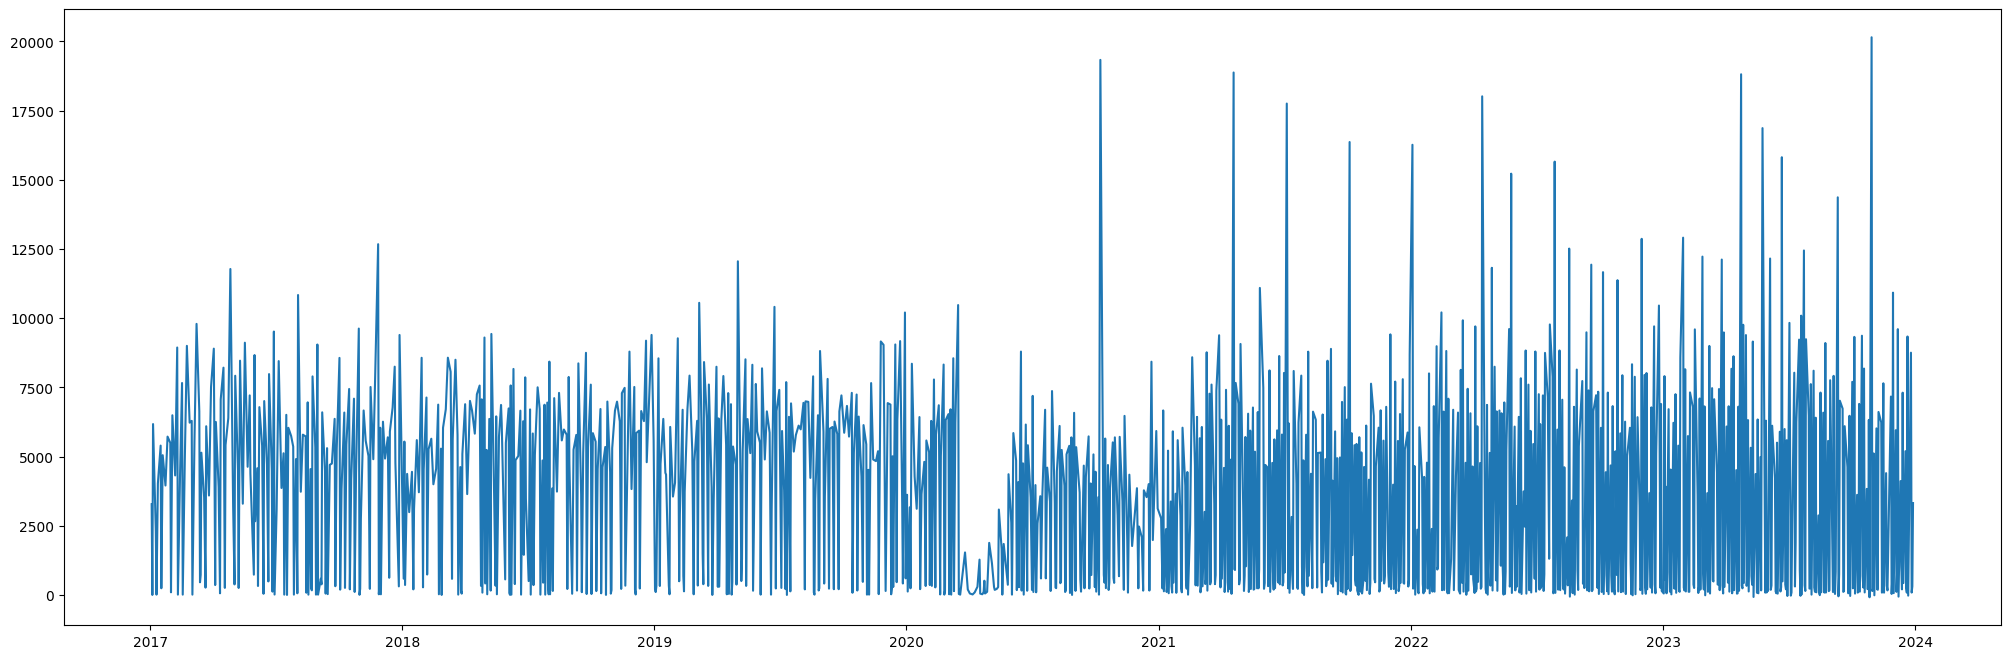

In [30]:
hy_vee_bottles_sold = hy_vee_des_moines.groupby('Date').sum()['Bottles Sold']
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(hy_vee_bottles_sold);

With the exception of the steep drop at the onset of the pandemic, we can see some semblance of peaks & valleys that suggest some seasonality in the data, so we'll almost certainly have to take that into account when modeling. Before we start a time-series split and running an augmented Dickey-Fuller test and ACF/PACF plots, we have a little more EDA to do here at the store-level.

In [31]:
len(hy_vee_des_moines['Vendor Name'].unique())

224

In [32]:
hy_vee_des_moines['Vendor Name'].value_counts()

Vendor Name
DIAGEO AMERICAS                                          23204
JIM BEAM BRANDS                                          16418
LUXCO INC                                                11962
SAZERAC COMPANY  INC                                      9187
BACARDI USA INC                                           8421
                                                         ...  
BOTTLE TREE BEVERAGE COMPANY LLC / CATHEAD DISTILLERY        1
STILLWORKS LLC                                               1
GEORGETOWN TRADING CO. LLC                                   1
BOM DIA IMPORTS LLC                                          1
OLD LOUISVILLE WHISKEY CO. LLC                               1
Name: count, Length: 224, dtype: int64

In [33]:
hvdm_vendor_counts = hy_vee_des_moines['Vendor Name'].value_counts()
hvdm__1000_order_vendors = pd.DataFrame(hvdm_vendor_counts)
hvdm__1000_order_vendors = hvdm__1000_order_vendors[hvdm__1000_order_vendors['count']>= 1000]
hvdm__1000_order_vendors

,count
Vendor Name,
DIAGEO AMERICAS,23204
JIM BEAM BRANDS,16418
LUXCO INC,11962
SAZERAC COMPANY INC,9187
BACARDI USA INC,8421
PERNOD RICARD USA,8265
HEAVEN HILL BRANDS,5355
PHILLIPS BEVERAGE,4687
PROXIMO,3993


In [34]:
print("Number of Vendors with at least 1000 orders fulfilled:", len(hvdm__1000_order_vendors))
print("Fraction of rows lost if we drop vendors with fewer than 1000 orders:", 1 - sum(hvdm__1000_order_vendors['count'] / len(hy_vee_des_moines)))

Number of Vendors with at least 1000 orders fulfilled: 23
Fraction of rows lost if we drop vendors with fewer than 1000 orders: 0.12423161180185649


So, if we drop the records pertaining to vendors with fewer orders, we lose 14.2% of the rows, but the vendor categories drop from an unwieldy 161 to a far more reasonable 19.

Ultimately, I'll keep the vendor column as-is, but I won't use it for modeling for now. If the overall goal is to take a model that optimizes time-series predictions on inventory and then apply it to numerous other stores, keeping it limited to the time-series data, liquor categories, and counts is a good starting place on its own.

Once this project reaches that minimum viability point, then I may be able to come back and include vendor data.

With this groundwork laid down, let's move on to modeling our time-series inventory data with a (S)ARIMA model.

## modeling

Below, I import the packages we'll need to valuate, preprocess, and evaluate the data.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

#Scikit-Learn modules for valuation & evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit

#Itertools for optimizing (S)ARIMA hyperparameters
import itertools

#StatsModels for modeling & ACF/PACF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignoring and models that will throw a warning about non-invertibility later
import warnings
warnings.filterwarnings("ignore")

Before I do anything with the data, I should **reduce the Hy-Vee Des Moines subset down to just one variable**: 'Bottles Sold'. Otherwise, I would be running multivariate data (with liqour categories and sale price) through a univariate model (ARIMA). Later, I can come back and try to include more of those variables.

Second, I'll perform a **valuation measure** to avoid data leakage. Specifically, I'll create a training & test set and then, within the train set, create a valuation set via TimeSeriesSplit.

Next, I'll **check to see whether the training data is stationary** and, if not, I'll have to stationarize it.

At the end of the ARIMA modeling process, I'll incorporate all five years (2012-2016) in order to **forecast** one year ahead.

But first, let's look at a sample of this subset to make sure we can make sense of everything.

In [36]:
hvdm = hy_vee_des_moines.set_index('Date')
hvdm = hvdm.sort_index()
hvdm.sample(50)

,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
Date,,,,,,,
2019-03-11,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,IMPORTED FLAVORED VODKA,370.0,PERNOD RICARD USA,36
2019-06-13,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,370.0,PERNOD RICARD USA,24
2017-03-23,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,MISCELLANEOUS SCHNAPPS,421.0,SAZERAC COMPANY INC,24
2017-07-13,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,IMPORTED FLAVORED VODKA,277.0,STOLI GROUP,12
2020-02-06,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RTD COCKTAILS,421.0,SAZERAC COMPANY INC,12
2019-06-24,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,AMERICAN FLAVORED VODKA,260.0,DIAGEO AMERICAS,12
2023-10-30,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,777.0,"BLUE OX SPIRITS, INC.",12
2017-07-27,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,IMPORTED FLAVORED VODKA,395.0,PROXIMO,12
2022-10-03,2633,HY-VEE #3 / BDI / DES MOINES,DES MOINES,RUM,260.0,DIAGEO AMERICAS,6


Okay, looking at the 'Bottles Sold' column, I'm just now realizing that there's [some *wholesale* data in this store's records](https://bdi-wholesale.com/#:~:text=As%20a%20Hy%2DVee%20company,well%20as%20superior%20customer%20service.) alongside what seem to be *individual, in-store* sales. Nonetheless, if the primary goal of this project is to predict the inventory this store needs to restock, then this little revelation doesn't really change anything about the project, so...let's keep at it.

However, this does make it clear that the 'Bottles Sold' column is the target as it ultimately reflects the amount of inventory moved more than anything else.

Below, I start by reducing the Hy-Vee subset down to one variable and giving it a more concise variable name of **'hvdm'** and running the time-series split.

As a side note, it seems that a lot of time-series projects will often resample to a weekly level, but [it appears that most grocers restock every day](https://www.instacart.com/company/ideas/when-do-grocery-stores-restock/#:~:text=Most%20of%20the%20larger%20grocery,store%20has%20its%20own%20schedule.), so I'll leave the granularity at the daily level for now.

In [37]:
hvdm = hvdm.groupby('Date').sum()['Bottles Sold']
hvdm.shape

(1340,)

In [38]:
# find the index which allows us to split off 20% of the data
cutoff = round(hvdm.shape[0]*0.8)
cutoff

1072

In [39]:
# Define train and test sets according to the index found above
train = hvdm[:cutoff]
test = hvdm[cutoff:]

In [40]:
# TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Test  index: [182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 23

Let's check for trends in the training time-series data via the Dickey-Fuller test:

In [41]:
d_f_test = adfuller(train)
d_f_test

(-5.383208030218027,
 3.673413783409225e-06,
 14,
 1057,
 {'1%': -3.4365517520261637,
  '5%': -2.86427826065702,
  '10%': -2.5682279541355597},
 19899.077692111012)

These results support the argument that we can reject the null hypotheses that our training data is not stationary in terms of trends, but it can't go so far as to dimiss concerns about **seasonality** without examining the data more on the monthly & weekly levels.

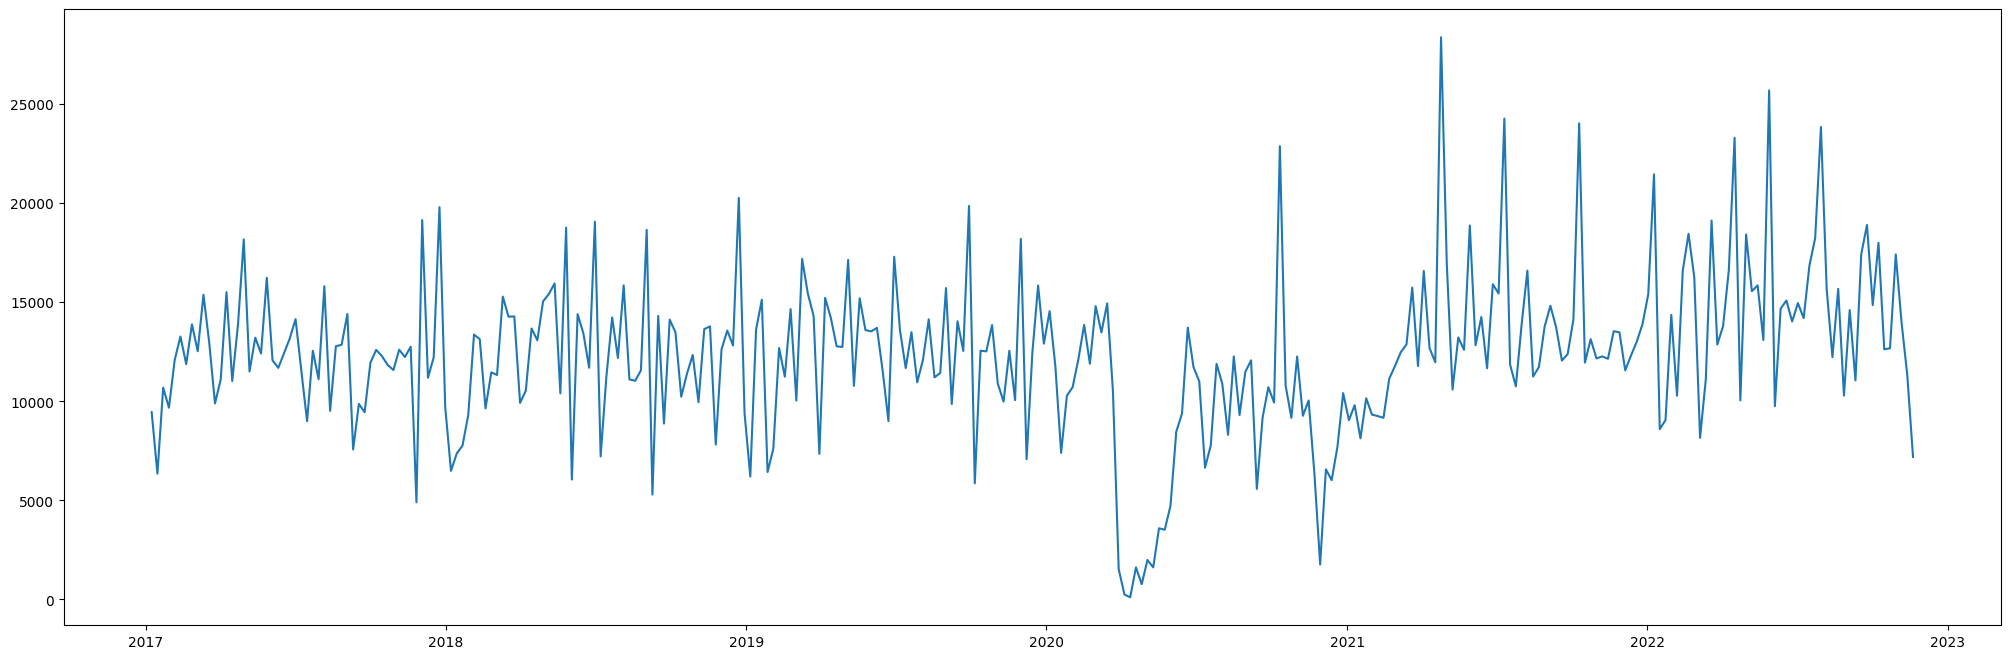

In [42]:
train_resampled_weekly = train.resample('W').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(train_resampled_weekly);

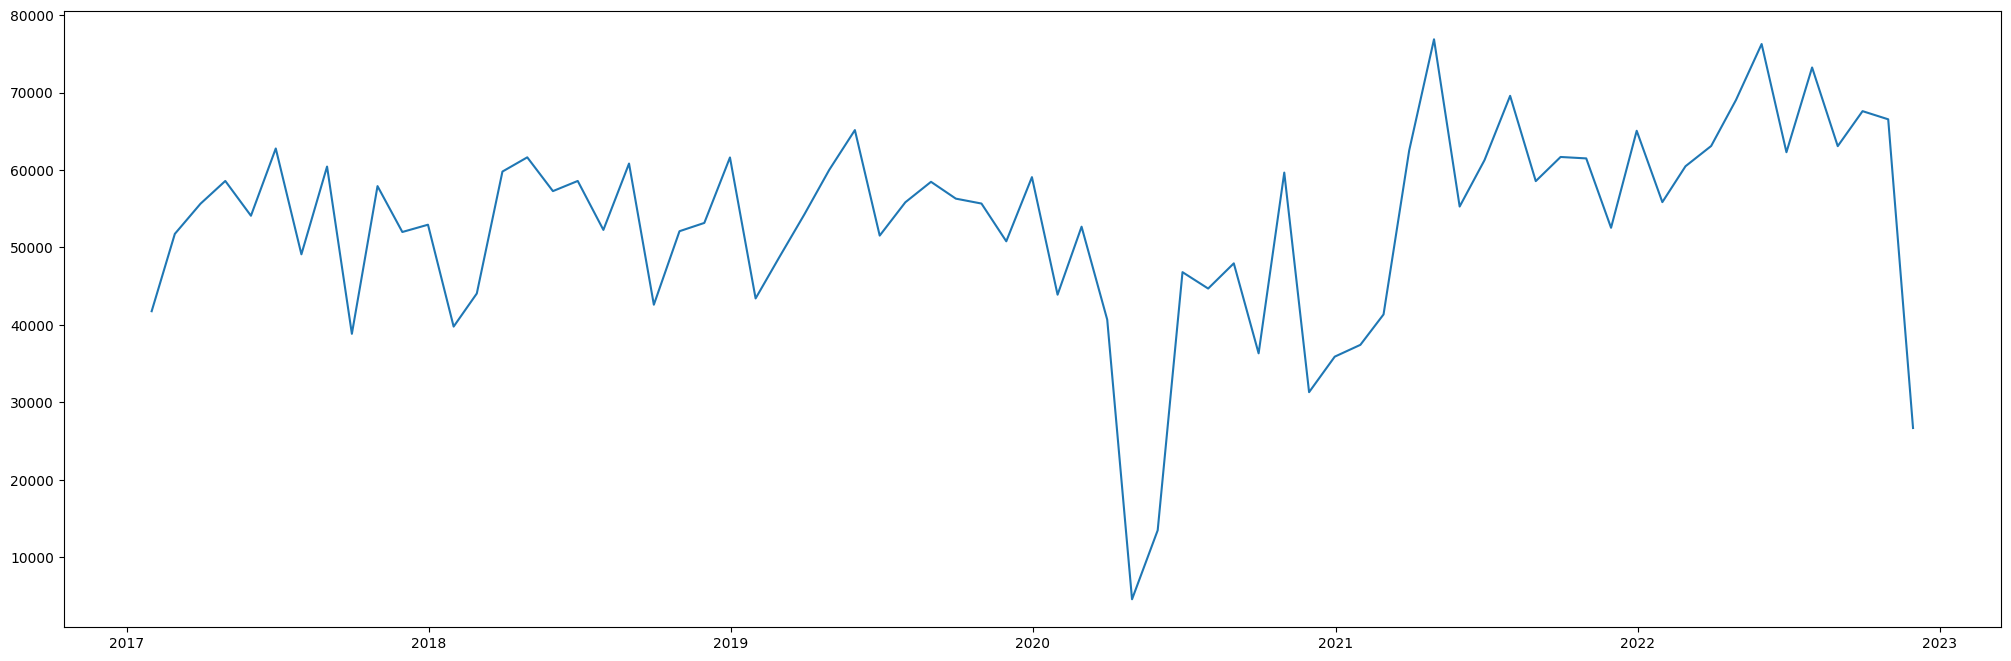

In [43]:
train_resampled_month = train.resample('M').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(train_resampled_month);

It seems like we might be looking at peaks around the 4th of July and lulls every fall, but these peaks & troughs vary.

To be sure, let's check the ACF & PACF to see if there are any lags in the data or if we can gain any insights into ARIMA hyperparameter-tuning.

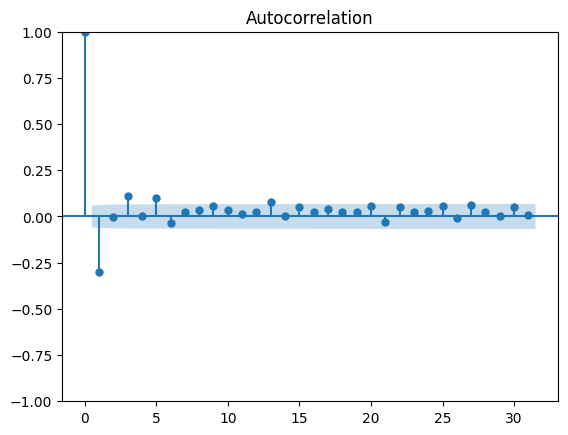

In [44]:
plot_acf(train);

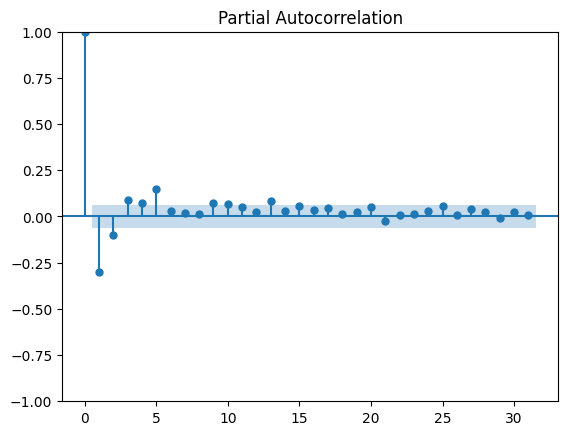

In [45]:
plot_pacf(train);

These plots aren't pointing to any obvious seasonality just yet, but it's definitely important to try different ARIMA parameters at least up to three lags to see what we'll find.

Let's just run a couple "baseline" ARIMAs (white-noise & random walk) and see how it looks.

In [46]:
#X_train_arima = X_train_encoded.drop(['Store Number', 'Vendor Name', 'Sale (Dollars)'], axis=1)
ar_white_noise_baseline = ARIMA(train, order=(0,0,0)).fit()
ar_white_noise_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Bottles Sold   No. Observations:                 1072
Model:                          ARIMA   Log Likelihood              -13441.586
Date:                Mon, 24 Jun 2024   AIC                          26887.173
Time:                        14:15:52   BIC                          26897.127
Sample:                             0   HQIC                         26890.944
                               - 1072                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3530.0168   1.11e+05      0.032      0.975   -2.14e+05    2.22e+05
sigma2      1.237e+10   7.57e+08     16.355      0.000    1.09e+10    1.39e+10
===================================================================================
Ljung-Box (L1) (Q):                  95.77   Jarque-Bera (JB):               110.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Before we try and optimize this model, it looks like we're getting a problematic error about the model's ability to forecast based on the time-series index.

Let's take a closer look at that index by examining the first few entries:

In [47]:
train[0:30]

Date
2017-01-03    3279
2017-01-04       1
2017-01-05    6174
2017-01-09    2307
2017-01-10      12
2017-01-12    4030
2017-01-16    5396
2017-01-17     242
2017-01-19    5050
2017-01-23    3954
2017-01-26    5721
2017-01-30    5495
2017-01-31      96
2017-02-02    6492
2017-02-06    4318
2017-02-09    8940
2017-02-10      12
2017-02-13    4206
2017-02-16    7658
2017-02-17      12
2017-02-20    4882
2017-02-23    9000
2017-02-27    6225
2017-03-02    6290
2017-03-03      12
2017-03-06    5583
2017-03-09    9794
2017-03-13    6632
2017-03-14     458
2017-03-15     730
Name: Bottles Sold, dtype: int64

I think irregularities in the dates in the form of gaps between days means the *frequency* of days isn't consistent, so it won't be able to forecast consistently.

This is a little annoying because I wanted to keep the time-series data on a daily scale since major grocers restock daily, but it looks like we'll have to resample to at least the weekly basis in order for ARIMA to be able to forecast.

In [48]:
#replace our 'ts' variable with the preexisting weekly one
train = train_resampled_weekly
#retry ARIMA
ar_white_noise_baseline = ARIMA(train, order=(0,0,0)).fit()
ar_white_noise_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Bottles Sold   No. Observations:                  307
Model:                          ARIMA   Log Likelihood               -2983.906
Date:                Mon, 24 Jun 2024   AIC                           5971.813
Time:                        14:15:52   BIC                           5979.266
Sample:                    01-08-2017   HQIC                          5974.793
                         - 11-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.233e+04    232.159     53.093      0.000    1.19e+04    1.28e+04
sigma2      1.634e+07   9.47e+05     17.253      0.000    1.45e+07    1.82e+07
===================================================================================
Ljung-Box (L1) (Q):                  28.62   Jarque-Bera (JB):                50.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

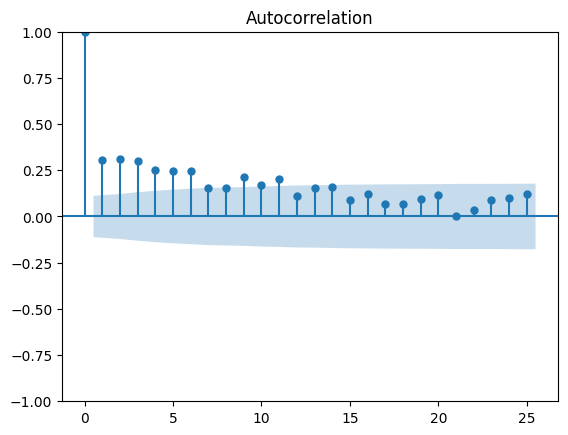

In [49]:
plot_acf(train);

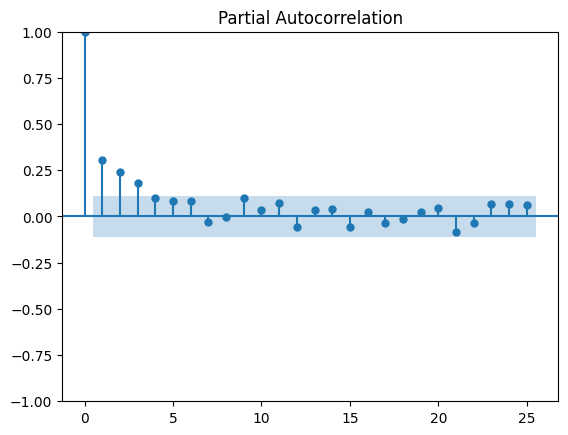

In [50]:
plot_pacf(train);

Looks like that solved the problem, the ACF/PACF plots look more like what we'd expect, and we'll be able to forecast once we're finished optimizing the model. **Normally, this is where we'd decide to simply skip ARIMA and move straight to a SARIMA model to account for some seasonality.** However, running that many hyperparameter settings via a parameter grid seems to be a little much on Google Colab - it takes too long and eats up a lot of RAM.

In this instance, **a workaround involves first running a baseline and then a parameter grid via ARIMA, then co-opting those params for SARIMA's p/d/q *and* P/D/Q seasonal settings.**

Looking ahead, we have an AIC score of 6,051 with this white noise baseline model. Let's also see how it looks with a random walk baseline:

In [51]:
ar_random_walk_baseline = ARIMA(train, order=(0,1,0)).fit()
ar_random_walk_baseline.aic

6051.115082224687

Things are improving, bu these aren't good AIC scores. We'll probably find better results once we swtich over to SARIMA, but just to be sure, let's also run a cross-validated RMSE to evaluate these different ARIMA settings and make it a function that can be easily applied later.

In [52]:
def cv_ts_rmse(model, train_data=train):
  #resetting the index for easier splitting for the RMSE
  train_with_ind = train_data.reset_index()
  #empty list to hold each fold's RMSE
  RMSEs = []
  #iterate through folds and append RMSE
  for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 0, 0)).fit()
    preds = ar.predict(start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    RMSEs.append(np.sqrt(mean_squared_error(true, preds)))
  #return the mean of all RMSEs
  RMSE_mean = np.mean(RMSEs)
  return RMSE_mean

In [53]:
#testing it out on our lowest-AIC model so far
cv_ts_rmse(ar_white_noise_baseline)

4237.07323355485

Now let's see whether we can improve on this with a parameter grid. For now, let's just go up to 3 lags/differences/moving-averages. We'll put this into a function we can use for the remainder of this project:

In [54]:
def optimize_ARIMA(train_data=train):

  #define ARIMA order params:
  param_grid = {'p': [1,2,3],
                'd': [1,2,3],
                'q': [1,2,3]}
  #turn them into a ParameterGrid
  grid = ParameterGrid(param_grid)
  #empty dictionary for holding AIC scores:
  AICs = {}
  #empty dictionary for holding RMSE scores:
  RMSEs = {}
  #iterate through params and append the AICs scores
  for params in grid:
    #this block will get the AIC score and the respective model order params
    # and won't run models whose params aren't invertible
    try:
      model = ARIMA(train_data,
                  order = (params['p'],
                           params['d'],
                           params['q'])).fit(method_kwargs={'maxiter':300})
      new_key = model.aic
      new_value = params
      AICs[new_key] = new_value
    except:
      continue

    #this block runs a cross-validated RMSE function on that same model
    #resetting the index for easier splitting for the RMSE
    train_with_ind = train_data.reset_index()
    #empty dictionary to hold each model's mean RMSE
    mean_RMSEs = {}
    #iterate through folds and append RMSE
    #empty list to hold each fold's RMSE
    for train_ind, val_ind in split.split(train_with_ind):
      fold_RMSEs = []
      preds = model.predict(start=val_ind[0], end=val_ind[-1])
      true = train_with_ind.iloc[val_ind, -1]
      fold_RMSEs.append(np.sqrt(mean_squared_error(true, preds)))
    #return the mean of all RMSEs
    RMSE_mean = np.mean(fold_RMSEs)
    new_RMSE_key = RMSE_mean
    RMSEs[new_RMSE_key] = params

  #return lowest AIC & RMSE
  lowest_AIC = min(AICs.items(), key=lambda x: x[0])
  lowest_RMSE = min(RMSEs.items(), key=lambda x: x[0])
  return lowest_AIC, lowest_RMSE

In [55]:
 optimize_ARIMA(train)

((2632.849037549335, {'d': 3, 'p': 2, 'q': 3}),
 (4122.265342883077, {'d': 1, 'p': 1, 'q': 3}))

I wanted to use two metrics to see whether they would agree on the optimal model, but they don't. AIC penalizes models as they grow more complex while RMSE doesn't. In other words, AIC may make for a simpler interpretation while RMSE priveledges accuracy.

Let's see how these two models compare when run against the larger test data.

In [56]:
arima_233 = ARIMA(train, order = (2,3,3)).fit(method_kwargs={'maxiter':300})
arima_113 = ARIMA(train, order = (1,1,3)).fit(method_kwargs={'maxiter':300})

In [57]:
#first we'll need to resample the test set on a weekly basis, but we
# have to drop the last week since it's incomplete
test = test.resample('W').sum()
#define the RMSE function
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1])
    return np.sqrt(mean_squared_error(test_data, y_hat))
#running the function
print('ARIMA model order (2,3,3) RMSE:', find_rmse_test(arima_233))
print('ARIMA model order (1,1,3) RMSE:', find_rmse_test(arima_113))

ARIMA model order (2,3,3) RMSE: 15767214.698978113
ARIMA model order (1,1,3) RMSE: 5010.91286347577


When it comes to the test data, the model with the lowest RMSE (arima_113) performed much better, but the RMSE on the test set (5,010) was worse than the training set (4,122). Something's definitely off (spoiler alert: it's the seasonality); let's visualize these predictions on the test data:

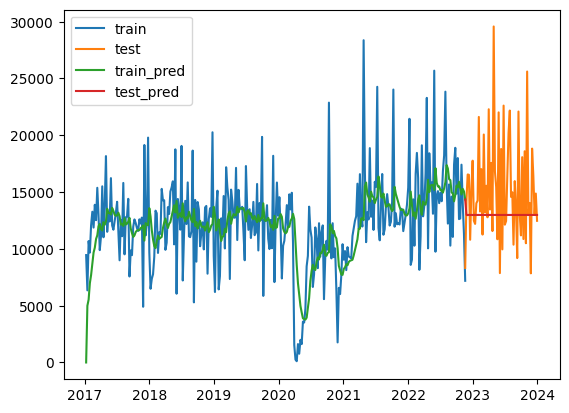

In [58]:
y_hat_train = arima_113.predict()
y_hat_test = arima_113.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

We can confirm that these predictions are failing to account for seasonality. Let's recheck the ACF plot with more lags in the picture.

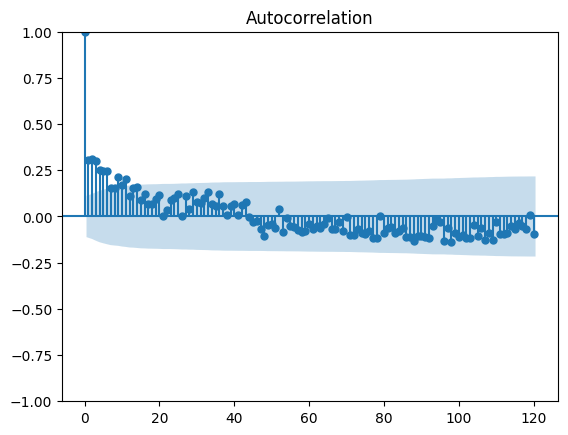

In [59]:
plot_acf(train, lags=120);

Ah, it's not overt, but there's definitely *some* seasonality going on at an annual cycle: a pattern emerges every 52 weeks above. Subsequently, we'll need to refine our model from ARIMA to SARIMA to take these seasonal effects into account.

In [60]:
sar_113 = SARIMAX(train,
                  order = (1,1,3),
                  seasonal_order = (1,1,3,52)).fit()
sar_113.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Bottles Sold   No. Observations:                  307
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 52)   Log Likelihood               -2482.143
Date:                            Mon, 24 Jun 2024   AIC                           4982.286
Time:                                    14:27:00   BIC                           5014.122
Sample:                                01-08-2017   HQIC                          4995.093
                                     - 11-20-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8734      0.229      3.806      0.000       0.424       1.323
ma.L1         -1.6303      0.247     -6.600      0.000      -2.114      -1.146
ma.L2          0.6895      0.235      2.936      0.003       0.229       1.150
ma.L3         -0.0415      0.109     -0.381      0.703      -0.255       0.172
ar.S.L52      -0.8342      3.174     -0.263      0.793      -7.055       5.387
ma.S.L52       0.1155      3.256      0.035      0.972      -6.266       6.497
ma.S.L104     -0.5100      2.280     -0.224      0.823      -4.979       3.959
ma.S.L156      0.0305      0.402      0.076      0.939      -0.757       0.818
sigma2       2.47e+07   5.27e-07   4.68e+13      0.000    2.47e+07    2.47e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                28.02
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.71e+31. Standard errors may be unstable.
"""

Okay, we see a better AIC score, what about the RMSE. Let's bring back the ARIMA train RMSE score for quick reference first, then run the SARIMA RMSE.

In [61]:
cv_ts_rmse(arima_113)

4237.07323355485

In [62]:
cv_ts_rmse(sar_113)

4237.07323355485

Okay, I guess I'm missing something here. Let's test the SARIMA version on the test set.

In [63]:
find_rmse_test(arima_113)

5010.91286347577

In [64]:
find_rmse_test(sar_113)

4433.09015452471

Not a good sign, let's visualize it ~(>_<。)

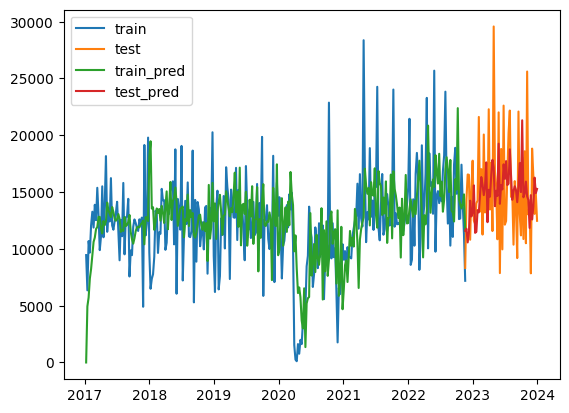

In [65]:
y_hat_train = sar_113.predict()
y_hat_test = sar_113.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

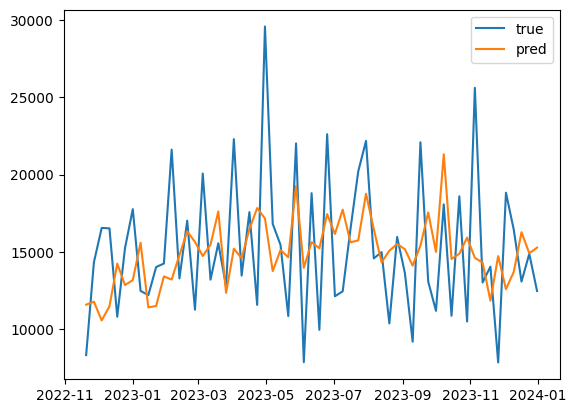

In [66]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

NOT. TOO. SHABBY. Not great, but not bad. I think part of what we see here is how the variance in liqour sales (except in 2012) increases during the latter half of the year. Let's finally forecast with all this data:

In [67]:
hvdm_weekly = hvdm.resample('W').count()
sar_hvdm = SARIMAX(hvdm_weekly,
                   order=(1, 1, 3),
                   seasonal_order=(1, 1, 3, 52)).fit()

In [68]:
forecast = sar_hvdm.forecast(steps=52)

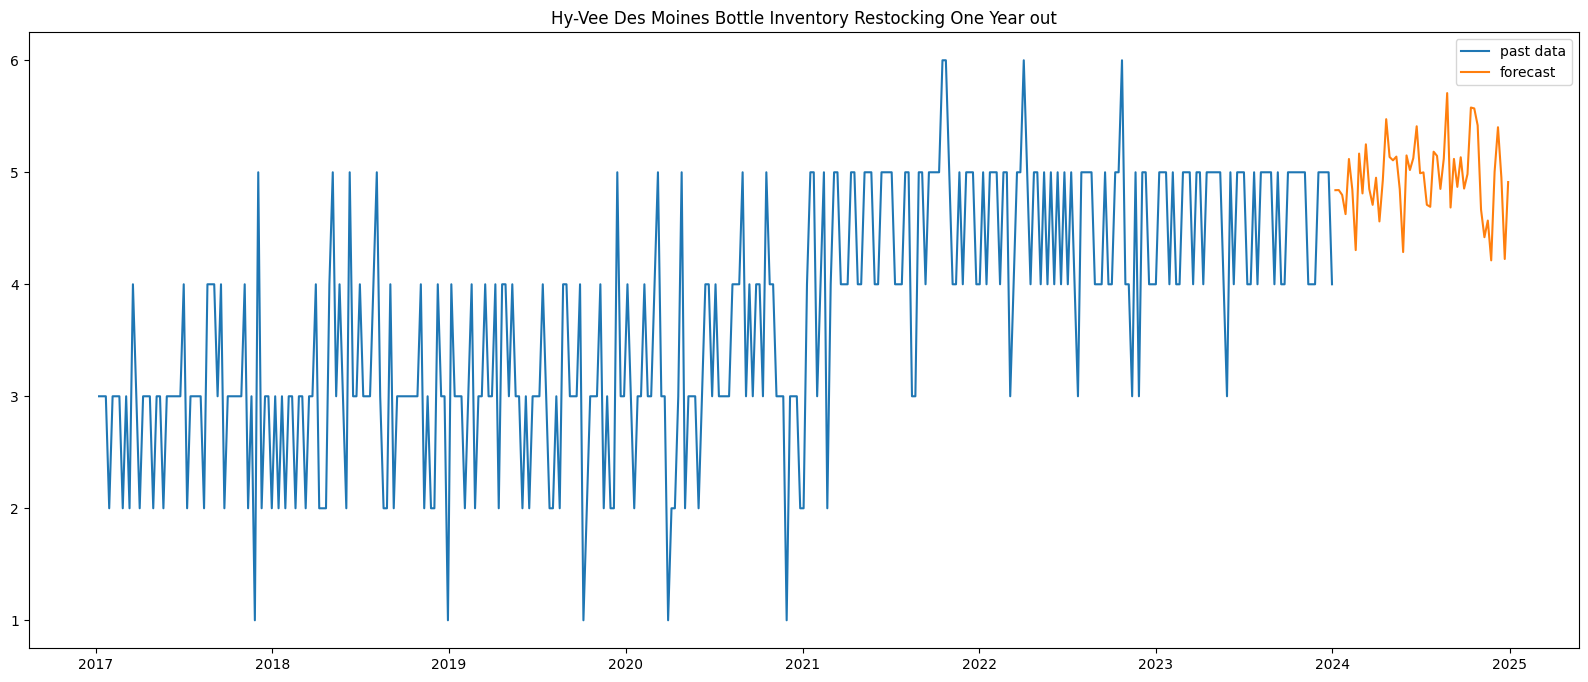

In [69]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(hvdm_weekly, label='past data')
ax.plot(forecast, label='forecast')
ax.set_title('Hy-Vee Des Moines Bottle Inventory Restocking One Year out')

plt.legend();

## streamlining this modeling process for other stores

We did a lot in order to finally reach the forecasting stage above. It involved a time-series split, resampling on a weekly basis, testing for trends, optimizing ARIMA parameters, discovering the data had seasonality even though I thought it didn't, recalibrating the test for SARIMA, and writing a few functions along the way.

Part of what took a while was getting to know this data on a smaller, store-specific scale. If we want to take this process and run it on a number of other stores in Iowa, we'd need to streamline this process by eliminating some of the EDA-like steps we took along the way above.

The next goal is to write a function that takes in an individual store's data from our earlier 'trimmed_df' and does the following:

### preprocessing
1. Drops every column except 'Bottles Sold'
2. Resamples the data on a weekly basis
3. Runs a time-series split for the training & test sets

### modeling
4. Running a ParameterGrid for all the params in SARIMA is taking too long for my Google Colab notebook and/or laptop to handle, so for now, we'll first run the optimize_ARIMA() function to find the best 'p', 'd', 'q' settings, then co-opt those for the SARIMA 'P', 'D', 'Q' settings like we did above.

### evaluating
5. Returns a visualization of how the optimal model performed on the test set so we can at least see whether the model seems to be doing a decent job.
6. Returns a forecast visualization for the next year.

This omits testing for trends via the Dickey-Fuller tests and assumes there will be seasonality like there was in the Hy-Vee Des Moines set, which is a potential risk I'm taking with the scope of this project in mind. However, returning the visualization of the predictions on the training & test data will at least help alert us if there's been a significant difference with a particular store's data or some sort of modeling problem.

I've already done a lot of the work that goes into this process; this is more of a matter of combining everything into one function. The main challenge will be taking the optimized ARIMA params and inserting them into the SARIMA params.

In [70]:
def Iowa_restock_bottles_forecast(store_data):

  #PREPROCESSING

  # turn data into a series and resample on a weekly basis
  store_data = store_data.groupby('Date').count()['Bottles Sold']
  store_data = store_data.resample('W').count()
  # find the index which allows us to split off 20% of the data
  cutoff = round(store_data.shape[0]*0.8)
  # Define train and test sets according to the index found above
  train = store_data[:cutoff]
  test = store_data[cutoff:]

  #MODELING via a more lightweight ARIMA process

  #define ARIMA order params:
  param_grid = {'p': [0,1,2,3],
                'd': [0,1,2,3],
                'q': [0,1,2,3]}

  #turn them into a ParameterGrid
  grid = ParameterGrid(param_grid)

  #empty dictionary for holding AIC scores:
  AICs = {}

  #iterate through params and append the AICs scores
  for params in grid:
    #this block will get the AIC score and the respective model order params
    model = ARIMA(train,
                  order = (params['p'],
                           params['d'],
                           params['q'])).fit(method_kwargs={'maxiter':300})
    new_key = model.aic
    new_value = params
    AICs[new_key] = new_value

  #find the lowest AIC model's param settings
  lowest_AIC = min(AICs.items(), key=lambda x: x[0])
  settings = lowest_AIC[1].values()
  settings_list = list(settings)

  #apply them to SARIMA's p/P, d/D, and q/Q settings
  sarima_model = SARIMAX(train,
                         order = (settings_list[0],
                                  settings_list[1],
                                  settings_list[2]),
                         seasonal_order = (settings_list[0],
                                           settings_list[1],
                                           settings_list[2],
                                           52)).fit()

  #EVALUATING AND VISUALIZING

  #return train & test set predictions visualization
  y_hat_train = sarima_model.predict()
  y_hat_test = sarima_model.predict(start=test.index[0], end=test.index[-1])

  fig, ax = plt.subplots()
  ax.plot(train, label='train')
  ax.plot(test, label='test')
  ax.plot(y_hat_train, label='train_pred')
  ax.plot(y_hat_test, label='test_pred')

  plt.legend();

  #refit all data for forecasting
  sar_store_data = SARIMAX(store_data,
                           order = (settings_list[0],
                                    settings_list[1],
                                    settings_list[2]),
                           seasonal_order = (settings_list[0],
                                             settings_list[1],
                                             settings_list[2],
                                             52)).fit()

  #return forecast visualization
  forecast = sar_store_data.forecast(steps=52)

  fig, ax = plt.subplots(figsize=(20, 8))
  ax.plot(store_data, label='past data')
  ax.plot(forecast, label='forecast')
  ax.set_title('Inventory Restocking One Year out')

  plt.legend();

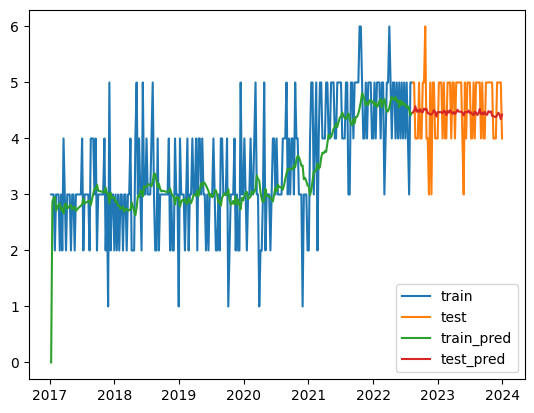

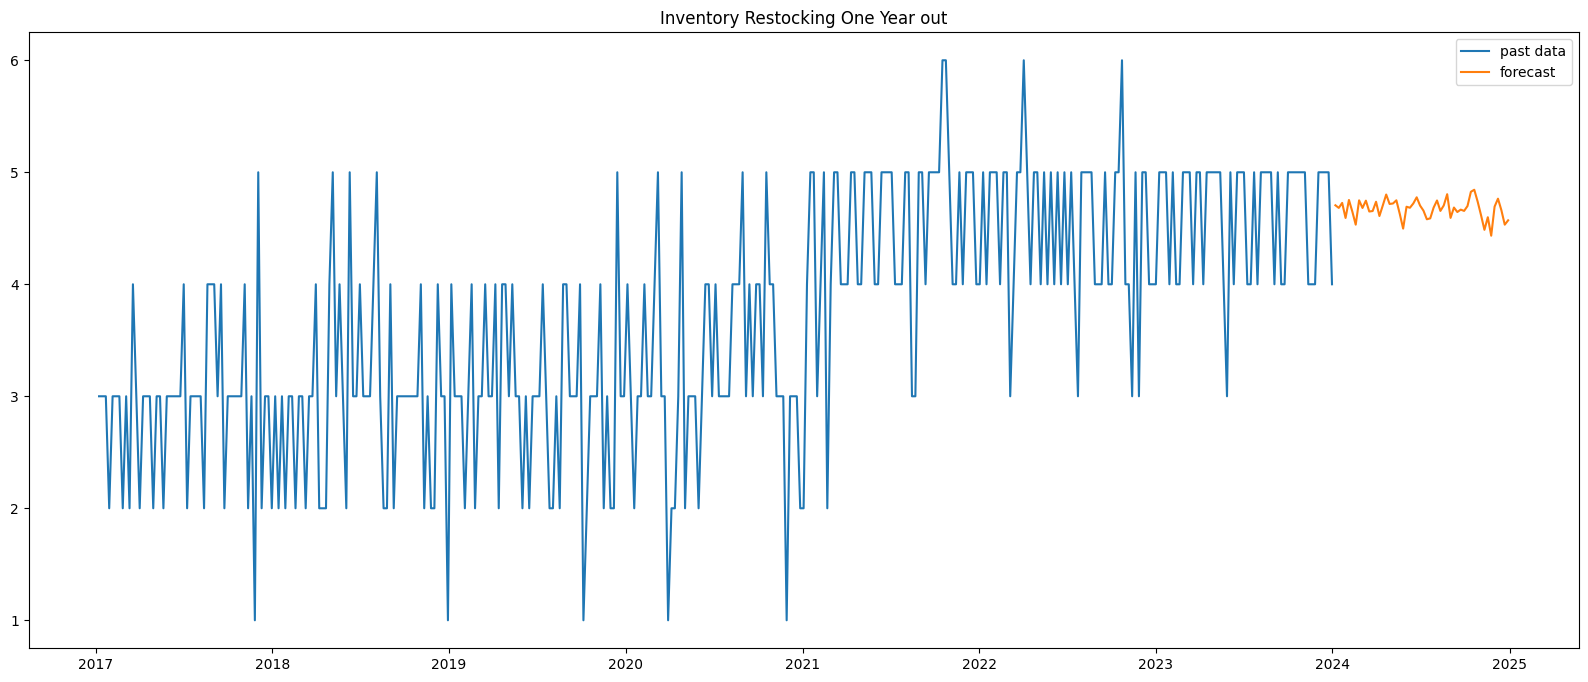

In [71]:
Iowa_restock_bottles_forecast(hy_vee_des_moines)

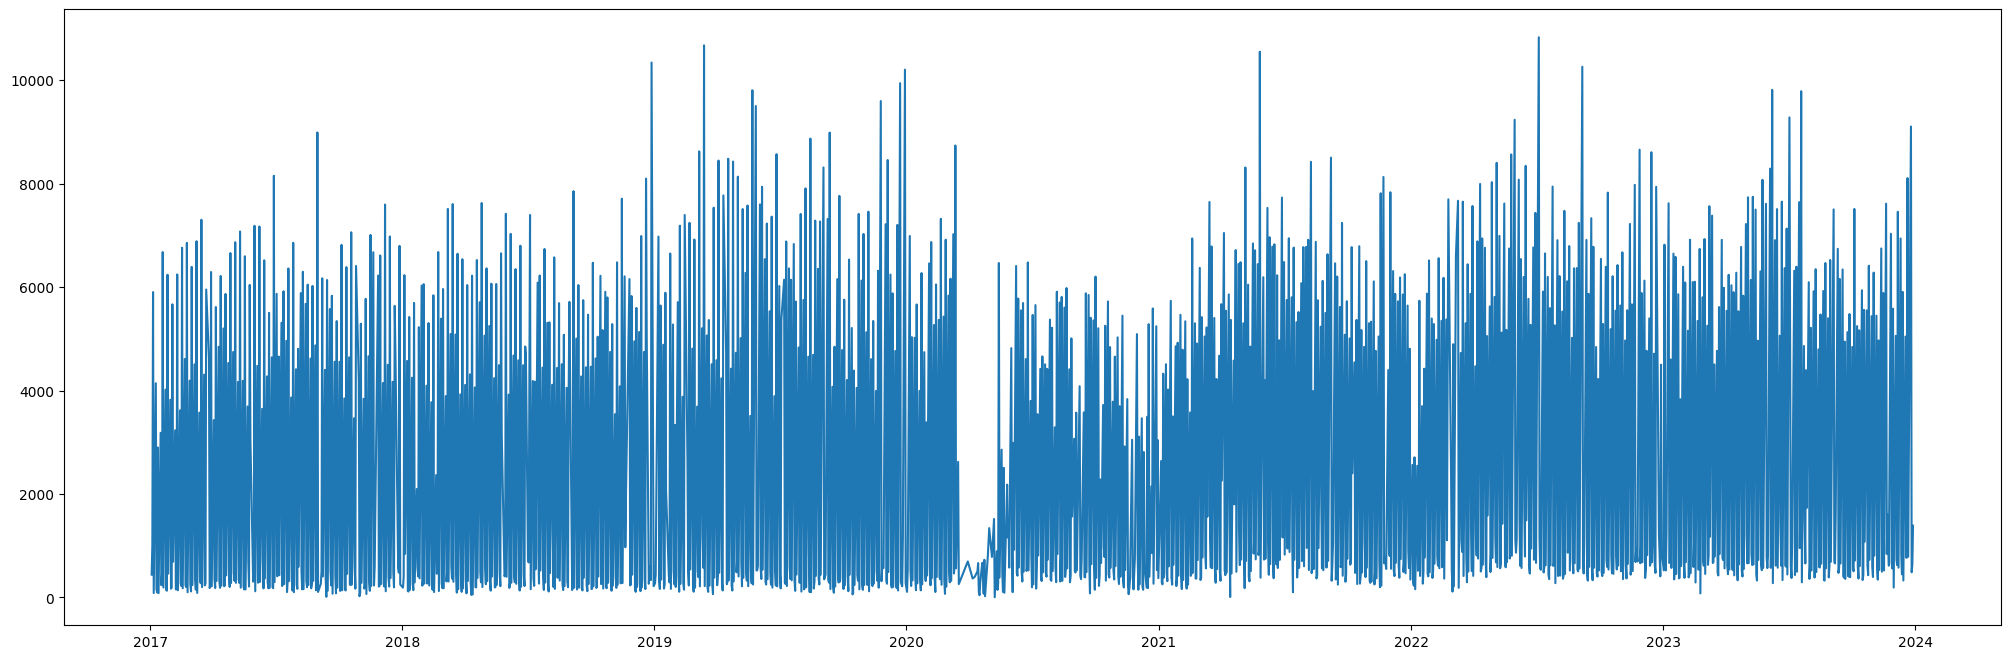

In [72]:
ccldm_bottles_sold_by_date = ccl_des_moines.groupby('Date').sum()['Bottles Sold']
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(ccldm_bottles_sold_by_date.index, ccldm_bottles_sold_by_date.values);

In [73]:
ccldm_bottles_sold_by_date

Date
2017-01-03     440
2017-01-04    1011
2017-01-05    5903
2017-01-06      85
2017-01-09    4141
              ... 
2023-12-22     788
2023-12-26    9105
2023-12-27     486
2023-12-28     637
2023-12-29    1386
Name: Bottles Sold, Length: 1755, dtype: int64

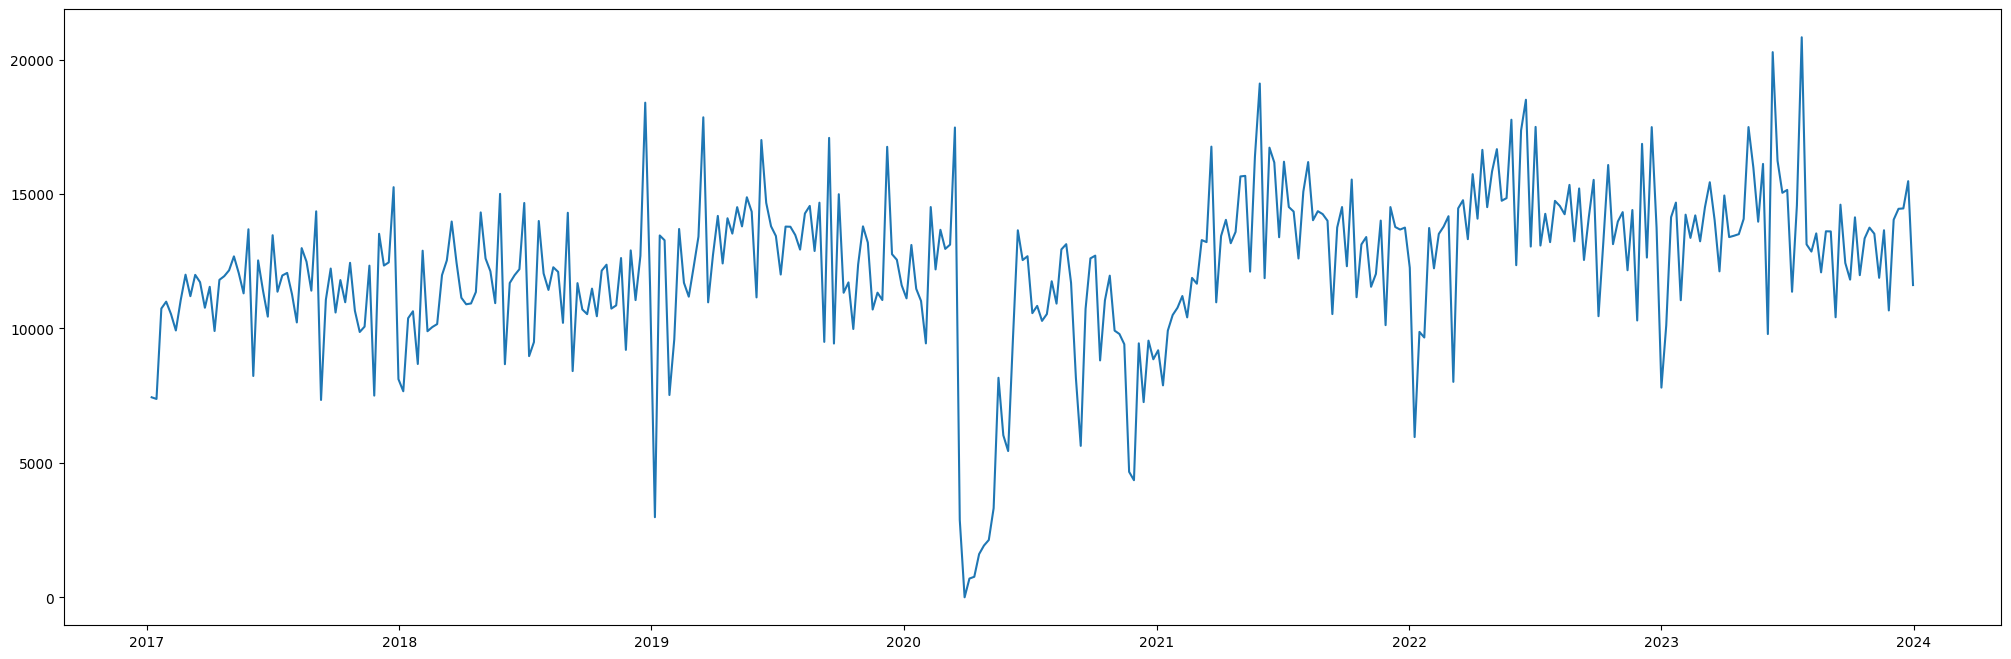

In [74]:
ccldm_bottles_sold_by_date_resampled_weekly = ccldm_bottles_sold_by_date.resample('W').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(ccldm_bottles_sold_by_date_resampled_weekly.index, ccldm_bottles_sold_by_date_resampled_weekly.values);

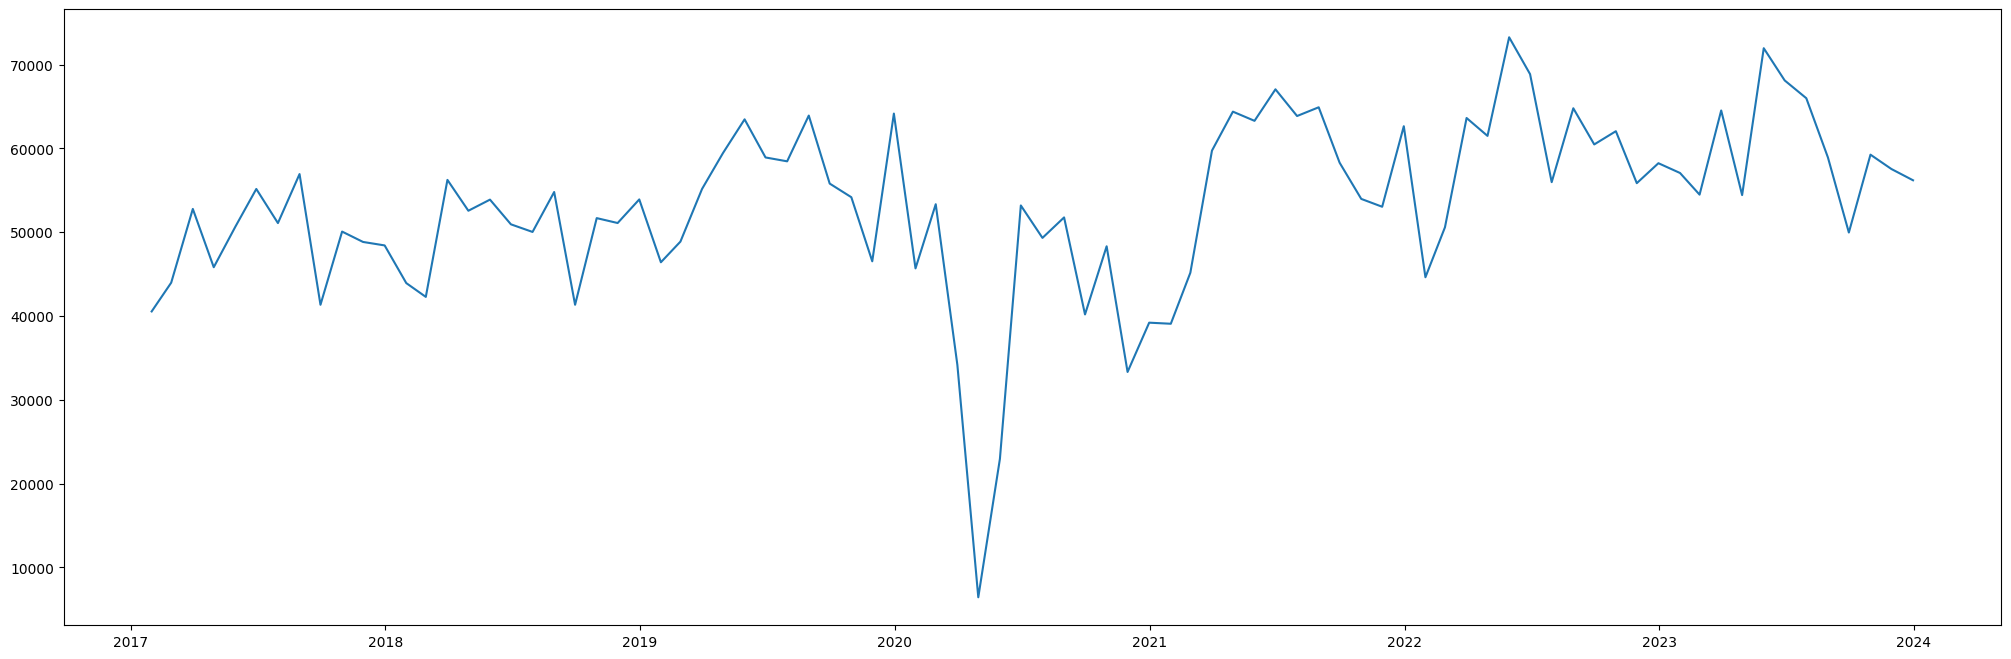

In [75]:
ccldm_bottles_sold_by_date_resampled_monthly = ccldm_bottles_sold_by_date.resample('M').sum()
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(ccldm_bottles_sold_by_date_resampled_monthly.index, ccldm_bottles_sold_by_date_resampled_monthly.values);

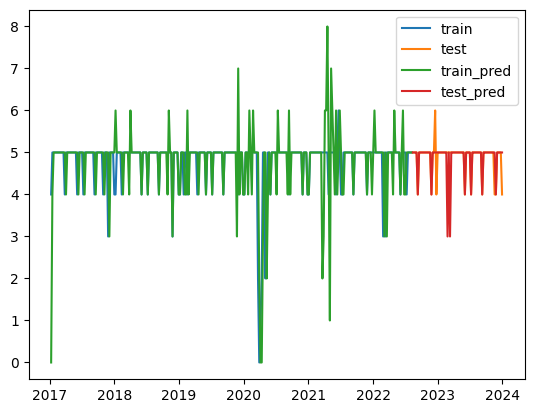

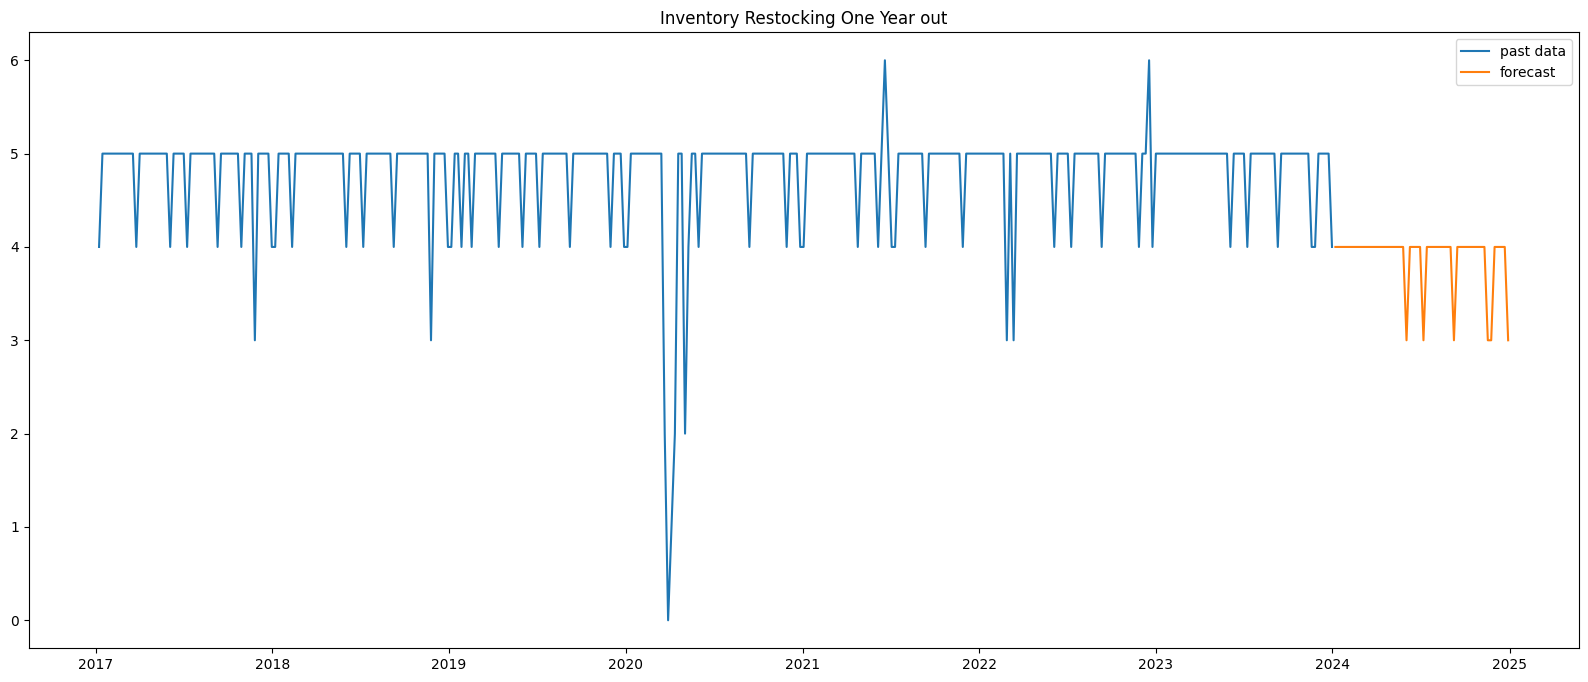

In [76]:
Iowa_restock_bottles_forecast(ccl_des_moines)

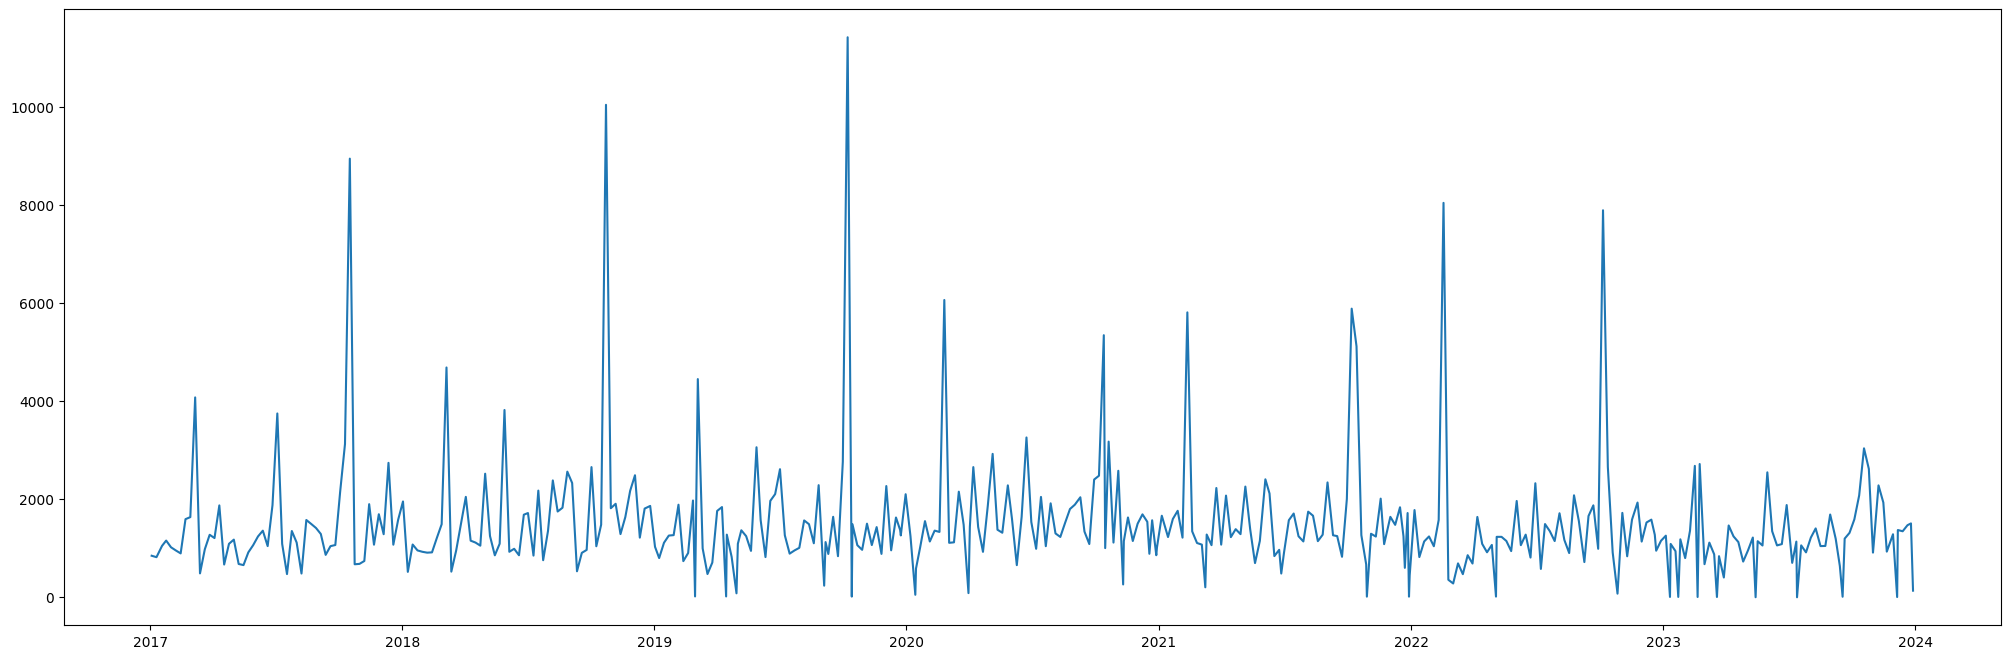

In [78]:
hvcf = hy_vee_cedar_falls
hvcf = hvcf.groupby('Date').sum()['Bottles Sold']
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(hvcf.index, hvcf.values);